In [1]:
import imf
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import constants as c
from matplotlib.colors import LogNorm
from astropy.visualization import quantity_support
quantity_support()
from astropy.io import ascii
from regions import CircleSkyRegion
from astropy.table import QTable, Table, Column
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5
from astropy.coordinates import Angle, Latitude, Longitude
from astropy import units as u
from astropy.table import Table, Column, join
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import regions
import re
#from regions import DS9Parser
from astropy.table import vstack
from astropy.io import fits
import warnings
from astropy.wcs import WCS
from uncertainties import ufloat
from uncertainties.umath import *
from radio_beam import Beam
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'lines.linewidth': 2})
from scipy.integrate import quad

In [2]:
import imf

In [3]:
kroupa = imf.Kroupa()
func_n = kroupa.dndm
func_m = kroupa.mass_weighted
m_min=0.03
m_max=120

In [4]:
base = '/orange/adamginsburg/sgrb2/NB/catalog_the_end/'
catNB3 = Table.read(base+'catalog_NB3_4RMS_30.0rings_0.7mindelta3npix_final_Nazar_review.csv', format='ascii')
catMB3 = Table.read(base+'catalog_MB3_4RMS_30.0rings_0.7mindelta3npix_final_Nazar_review.csv', format='ascii')
catNB6 = Table.read(base+'catalog_NB6_4RMS_30.0rings_0.7mindelta3npix_final_Nazar_review.csv', format='ascii')
catMB6 = Table.read(base+'catalog_MB6_4RMS_30.0rings_0.7mindelta3npix_final_Nazar_review.csv', format='ascii')

In [5]:
from purify_catalog import cat_purification_cores
from purify_catalog import HII_catalogs
#cat_NB3_HII_candidates, cat_MB3_HII_candidates, cat_NB3_HII, cat_MB3_HII, cat_NB6_HII_candidates, cat_MB6_HII_candidates, cat_NB6_HII, cat_MB6_HII = HII_catalogs(catNB3, catNB6, catMB3, catMB6)
catNB3_m, catMB3_m, catNB6_m, catMB6_m = cat_purification_cores(catNB3, catMB3, catNB6, catMB6)
catNB3_HII, catNB3_HII_cand, catNB3_HII_new, catMB3_HII, catMB3_HII_cand, catMB3_HII_new, catNB6_HII, catNB6_HII_cand, catNB6_HII_new, catMB6_HII, catMB6_HII_cand, catMB6_HII_new = HII_catalogs(catNB3, catNB6, catMB3, catMB6)

Removed 198 sources for the complete catalog
Removed 9 sources for the medium catalog
Removed 81 sources for the robust catalog
Removed 186 sources for the complete catalog
Removed 7 sources for the medium catalog
Removed 47 sources for the robust catalog
Removed 203 sources for the complete catalog
Removed 6 sources for the medium catalog
Removed 58 sources for the robust catalog
Removed 203 sources for the complete catalog
Removed 8 sources for the medium catalog
Removed 32 sources for the robust catalog


/orange/adamginsburg/sgrb2/NB/python_env_test/lib/python3.9/site-packages/astropy/table/table.py:1412: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  newcol = col[slice_]
/home/nbudaiev/.local/lib/python3.9/site-packages/numpy/ma/core.py:3224: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/home/nbudaiev/.local/lib/python3.9/site-packages/numpy/ma/core.py:3256: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be 

In [6]:
x_mass = np.linspace(0.03,120,1000)

In [7]:
def kappa(nu, nu0=271.1*u.GHz, kappa0=0.0114*u.cm**2*u.g**-1, beta=1.75):
    """
    Compute the opacity $\kappa$ given a reference frequency (or wavelength)
    and a power law governing the opacity as a fuction of frequency:
    $$ \kappa = \kappa_0 \left(\\frac{\\nu}{\\nu_0}\\right)^{\\beta} $$
    The default kappa=0.0114 at 271.1 GHz comes from extrapolating the
    Ossenkopf & Henning 1994 opacities for the thin-ice-mantle, 10^6 year model
    anchored at 1.0 mm with an assumed beta of 1.75.
    Parameters
    ----------
    nu: astropy.Quantity [u.spectral() equivalent]
        The frequency at which to evaluate kappa
    nu0: astropy.Quantity [u.spectral() equivalent]
        The reference frequency at which $\kappa$ is defined
    kappa0: astropy.Quantity [cm^2/g]
        The dust opacity per gram of H2 along the line of sight.  Because of
        the H2 conversion, this factor implicitly includes a dust to gas ratio
        (usually assumed 100)
    beta: float
        The power-law index governing kappa as a function of nu
    """
    return (kappa0*(nu.to(u.GHz,u.spectral())/nu0.to(u.GHz,u.spectral()))**(beta)).to(u.cm**2/u.g)

In [8]:
T = 50 * u.K
d = 8.4 * u.kpc
B3freq = 92.45* u.GHz
B6freq = 225.78 * u.GHz

kappaB3 = kappa(B3freq)
kappaB6 = kappa(B6freq)

In [9]:
def get_mass(flux, freq):
    return (flux*u.Jy * d**2 *(c.c**2)/ (2*kappa(freq)*freq**2*c.k_B*T)).to(u.Msun)

In [10]:
m_max = 120

In [11]:
def gaussian(x, x0=0, width=1):
    return np.exp(-(x-x0)**2/(2*width**2))

def apperture_corr(cat):
    true = quad(gaussian, -np.inf, np.inf)[0]
    adjusted_flux_array = []
    for core in cat:
        min_value = core['ring_std'] * 4 # multiplying by 4 beacause the min_value was set to 4 sigma
        peak_flux = core['peak']
        a = min_value / peak_flux
        crop = np.sqrt(-2*np.log(a))
        ratio_true_obs = true / (quad(gaussian, -crop, crop)[0])
        
        adjusted_flux = core['flux'] * ratio_true_obs
        
        adjusted_flux_array += [adjusted_flux]
        
    return adjusted_flux_array

In [12]:
# My assumed sensetivity within 0.5 pc: NB3: 0.2 mJy, MB3: 0.3 mJy. (0.3, 0.4 respectively for the whole FOV)

In [13]:
def inferred_mass_2(cat, radius, freq, comp_star, flux_type, number_of_HII):
    cat_cut = cat[cat['radial_d_AU'] < radius]
    
    # number of cores within the given radius and sensetivity limits
    N_cores = len(cat_cut)
    print(f'N_cores: {N_cores}')

    # stellar mass of the cores from above (33% SFE) 
    core_stellar_masses = get_mass(apperture_corr(cat_cut), freq) / 3.0
    M_obs_cores = np.sum(core_stellar_masses)
    print(f'M_obs_cores: {round(M_obs_cores.value)}')
    
    # mass fraction for the cores
    mass_ratio_cores = kroupa.m_integrate(comp_star, 20)[0] / kroupa.m_integrate(m_min, m_max)[0]
    # stellar mass of the whole core population, iferred down from our sensetivity limit
    M_obs_cores_cut = np.sum(core_stellar_masses[core_stellar_masses.value > comp_star])
    
    ###M_inf_cores = M_obs_cores / mass_ratio_cores
    M_inf_cores = M_obs_cores_cut / mass_ratio_cores
    print(f'M_inf_cores: {round(M_inf_cores.value)}')
    
    print(f'Number of HII regions: {number_of_HII}')
    
    M_obs_HII = number_of_HII * 45.5
    M_obs_tot = M_obs_HII + M_obs_cores.value
    print(f'M_obs_tot: {round(M_obs_tot)}')
    
    mass_ratio_core_HII = kroupa.m_integrate(comp_star, m_max)[0] / kroupa.m_integrate(m_min, m_max)[0]
    #M_inf_HII = M_obs_HII / mass_ratio_HII
    
    M_inf_tot = (M_obs_cores_cut.value+M_obs_HII) / mass_ratio_core_HII
    #M_inf_tot = (M_obs_cores_cut.value+M_obs_HII) / mass_ratio_cores
    
    print(f'M_inf_tot: {round(M_inf_tot)}')

In [14]:
# values for Table 2

In [15]:
inferred_mass_2(catNB3_m, 0.4*u.pc, B3freq, 1.0, 'flux', 11)

N_cores: 105
M_obs_cores: 1009
M_inf_cores: 2408
Number of HII regions: 11
M_obs_tot: 1510
M_inf_tot: 2808


In [16]:
inferred_mass_2(catMB3_m, 0.5*u.pc, B3freq, 1.5, 'flux', 57)

N_cores: 68
M_obs_cores: 550
M_inf_cores: 1623
Number of HII regions: 57
M_obs_tot: 3143
M_inf_tot: 6899


In [17]:
##############

In [18]:
# Below is out of date (and wrong), but could be useful later

In [19]:
func_n = kroupa.dndm
func_m = kroupa.mass_weighted
m_min=0.03
m_max=120
def inferred_mass(cat, radius, freq, comp_star, flux_type, number_of_HII):
    cat_m = cat[cat['radial_d_AU'] < radius]
    core_star_mass_all = np.sum(get_mass(apperture_corr(cat_m), freq)) / 3
    cat_m = cat_m[get_mass(apperture_corr(cat_m), freq) > (comp_star * 3 * u.Msun)]
    ratio_core = integrate.quad(func_m, comp_star, m_max)[0] / integrate.quad(func_m, m_min, m_max)[0]
    #ratio_core = integrate.quad(func_m, comp_star, 50)[0] / integrate.quad(func_m, m_min, m_max)[0] # using m_* max = 50 Msun from the core
    ratio_HII = integrate.quad(func_m, 20, m_max)[0] / integrate.quad(func_m, m_min, m_max)[0]
    ratio_core_HII = integrate.quad(func_m, comp_star, m_max)[0] / integrate.quad(func_m, m_min, m_max)[0]
    core_star_mass = np.sum(get_mass(apperture_corr(cat_m), freq)) / 3
    HII_star_mass = number_of_HII * 45 * u.Msun
    
    m_inferred_core = round((core_star_mass / ratio_core).value)
    m_inferred_HII = round((HII_star_mass / ratio_HII).value)
    m_inferred_total = round(((core_star_mass+HII_star_mass) / ratio_core_HII).value)
    
    return core_star_mass_all, m_inferred_core, m_inferred_HII, m_inferred_total

In [20]:
radius = 0.5 * u.pc
flux_type = 'flux'
freq = B3freq
comp_star = 1
cat = catNB3_m
cat_m = cat[cat['radial_d_AU'] < radius]
cat_upd = cat_m[get_mass(apperture_corr(cat_m), freq) > (comp_star * 3 * u.Msun)]
ratio = integrate.quad(func_n, comp_star, m_max)[0] / integrate.quad(func_m, m_min, m_max)[0]

In [21]:
###
#N: 6 HII regions. (+ 1 from meng compared to schmiedeke)
#M: 53
###

In [22]:
#N - 0.4 pc, 2400 msun
#M - 0.5 pc  20700 msun

In [23]:
# N_count is set up in a wrong way

In [24]:
# original values: N 1.0, M 1.5 Msun 
# 6 sigma within 90% of the pointing area: N 0.65, M 0.91 -> N 9.5, M 13.5 core mass, N 3.1, M 4.5

In [25]:
core_star_mass_NB3, m_inferred_core_NB3, m_inferred_HII_NB3, m_inferred_total_NB3 = inferred_mass(catNB3_m, 0.4*u.pc, B3freq, 1.0, 'flux', 6)
core_star_mass_MB3, m_inferred_core_MB3, m_inferred_HII_MB3, m_inferred_total_MB3 = inferred_mass(catMB3_m, 0.5*u.pc, B3freq, 1.5, 'flux', 53)
#NB6_mass = inferred_mass(catNB6_m, 0.4*u.pc, B6freq, mass_comp, 'flux')
#MB6_mass = inferred_mass(catMB6_m, 0.5*u.pc, B6freq, mass_comp, 'flux')
print('NB3:')
print('N_count: ' + str(core_star_mass_NB3))
print('N inferred (cores): ' + str(m_inferred_core_NB3))
print('N inferred (HII): ' + str(m_inferred_HII_NB3))
print('N inferred (total): ' + str(m_inferred_total_NB3))

print('MB3:')
print('M_count: ' + str(core_star_mass_MB3))
print('M inferred (cores): ' + str(m_inferred_core_MB3))
print('M inferred (HII): ' + str(m_inferred_HII_MB3))
print('M inferred (total): ' + str(m_inferred_total_MB3))

NB3:
N_count: 1009.3174335383852 solMass
N inferred (cores): 1874
N inferred (HII): 2271
N inferred (total): 2378
MB3:
M_count: 549.9729479724487 solMass
M inferred (cores): 1199
M inferred (HII): 20057
M inferred (total): 6441


In [26]:
mass_comp = np.logspace(-1, 1, 100)

inferred_massesNB3 = [np.nan] * len(mass_comp)
for i in range(len(mass_comp)):
    inferred_massesNB3[i] = inferred_mass(catNB3_m, 0.4*u.pc, B3freq, mass_comp[i], 'flux', 6)[3]

inferred_massesMB3 = [np.nan] * len(mass_comp)
for i in range(len(mass_comp)):
    inferred_massesMB3[i] = inferred_mass(catMB3_m, 0.5*u.pc, B3freq, mass_comp[i], 'flux', 53)[3]

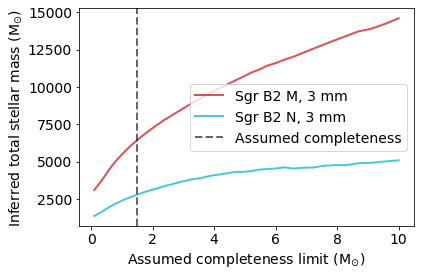

In [27]:
plt.plot(mass_comp, inferred_massesMB3, label = 'Sgr B2 M, 3 mm', color = 'tab:red', alpha = 0.8)
plt.plot(mass_comp, inferred_massesNB3, label = 'Sgr B2 N, 3 mm', color = 'tab:cyan', alpha = 0.8)
#plt.title('MB3')
plt.xlabel(r'Assumed completeness limit (M$_{\odot}$)')
plt.ylabel(r'Inferred total stellar mass (M$_{\odot}$)')
#plt.xscale('log')
plt.axvline(1.5, label = 'Assumed completeness', color = 'k', alpha = 0.6, linestyle = '--')
#plt.axvline(4, label = 'Assumed completeness 2', color = 'k', alpha = 0.6, linestyle = '--')
plt.legend()
#plt.xscale('log')
plt.savefig('inferred_mass_variations.png',dpi=300,bbox_inches='tight')

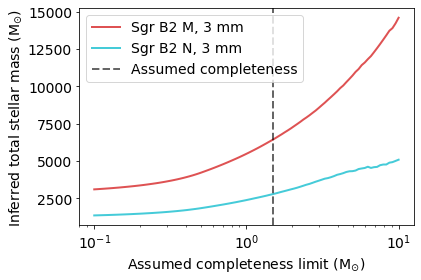

In [28]:
plt.plot(mass_comp, inferred_massesMB3, label = 'Sgr B2 M, 3 mm', color = 'tab:red', alpha = 0.8)
plt.plot(mass_comp, inferred_massesNB3, label = 'Sgr B2 N, 3 mm', color = 'tab:cyan', alpha = 0.8)
#plt.title('MB3')
plt.xlabel(r'Assumed completeness limit (M$_{\odot}$)')
plt.ylabel(r'Inferred total stellar mass (M$_{\odot}$)')
#plt.xscale('log')
plt.axvline(1.5, label = 'Assumed completeness', color = 'k', alpha = 0.6, linestyle = '--')
plt.legend()
plt.xscale('log')
#plt.savefig('inferred_mass_variations.png',dpi=300,bbox_inches='tight')